In [233]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter

In [234]:
def log_normal_int_dist(ln_mean, ln_std, size, round=False, max_val=30):
    mean = np.log(
        ln_mean ** 2 / np.sqrt(ln_std ** 2 + ln_mean ** 2)
    )  # Computes the mean of the underlying normal distribution
    sigma = np.sqrt(
        np.log(ln_std ** 2 / ln_mean ** 2 + 1)
    )  # Computes sigma for the underlying normal distribution
    samples = np.random.lognormal(mean=mean, sigma=sigma, size=size)
    samples = np.clip(samples, a_min=0, a_max=max_val)
    if round:
        # round to integer
        samples = np.round(samples)
    return samples

7.067382240985678


(0.0, 50.0)

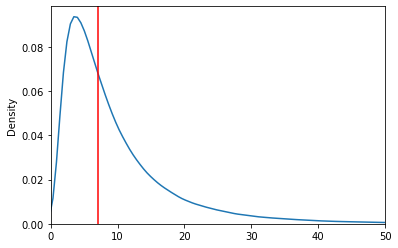

In [273]:
N = 1_000_000
ln_mean=10
ln_std=10


los = log_normal_int_dist(ln_mean=ln_mean, ln_std=ln_std, size=N, round=False, max_val=100)

fig, ax = plt.subplots(1,1)
sns.kdeplot(los, ax=ax)
ax.axvline(np.median(los), color='r')
true_median = np.median(los)
print(true_median)
ax.set_xlim(0,50)

Text(0, 0.5, 'New hospitalized')

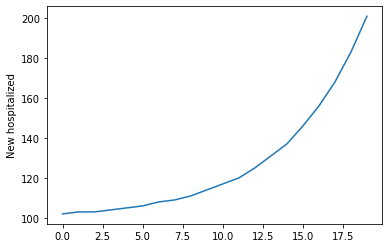

In [281]:
times = np.arange(20)
new_hosped_at_t = np.round(np.exp(0.2*times-10)*5e4).astype(int) + 100

fig, ax = plt.subplots(1,1)
ax.plot(times, new_hosped_at_t)
ax.set_ylabel('New hospitalized')

In [293]:
t_adm = []
los = []

for t in times:
    t_adm = t_adm + (list(t*np.ones(shape=new_hosped_at_t[t])))
    los = los + list(log_normal_int_dist(ln_mean=ln_mean, ln_std=ln_std, size=new_hosped_at_t[t], round=False, max_val=50))

los = np.array(los)
t_adm = np.array(t_adm)

t_release = t_adm + los


total_hosped = np.zeros_like(times)
median_los_7day = np.zeros_like(times, dtype=float)
for t in times:
    total_hosped[t] = np.sum((t>=t_adm)&(t<t_release))
    if t>=7:
        # idx = ((t<=t_release) & (t>t_release-7))
        idx = (t_adm<=t)&(t_release<=t)
        median_los_7day[t] = np.median(los[idx])

In [294]:
median_los_7day

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 2.91263088, 2.99864048, 3.36437321,
       3.52191597, 3.82267698, 4.03937453, 4.23231462, 4.2609685 ,
       4.34741377, 4.52079154, 4.56898691, 4.60673855, 4.6360452 ])

Text(0, 0.5, 'Median LOS')

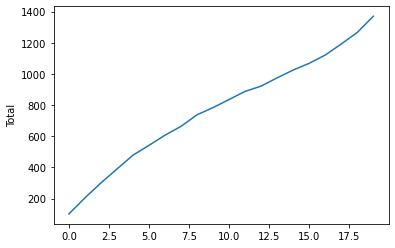

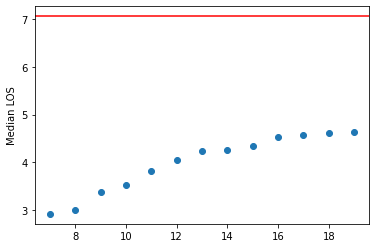

In [295]:
fig, ax = plt.subplots(1,1)
ax.plot(times, total_hosped)
ax.set_ylabel('Total')


fig, ax = plt.subplots(1,1)
ax.scatter(times[7:], median_los_7day[7:])
ax.axhline(true_median, color='r')
# ax.set_ylim(5,8)

ax.set_ylabel('Median LOS')


# KM

In [285]:
t_adm = []
los = []

for t in times:
    t_adm = t_adm + (list(t*np.ones(shape=new_hosped_at_t[t])))
    los = los + list(log_normal_int_dist(ln_mean=ln_mean, ln_std=ln_std, size=new_hosped_at_t[t], round=False, max_val=50))

los = np.array(los)
t_adm = np.array(t_adm)

t_release = t_adm + los


total_hosped = np.zeros_like(times)
median_los_7day = np.zeros_like(times, dtype=float)


for t in times:
    total_hosped[t] = np.sum((t>=t_adm)&(t<t_release))

    if t>=0:
        event_times = np.zeros_like(t_adm)
        events = np.zeros_like(t_adm)
        
        idx_censored = (t_release>t)
        event_times[idx_censored] = t - t_adm[idx_censored]
        events[idx_censored] = 0

        idx_event = (t_release<=t) 
        event_times[idx_event] = los[idx_event]
        events[idx_event] = 1

        idx_ok = ((t>=t_adm))
        event_times = event_times[idx_ok]
        events = events[idx_ok]


        kmf = KaplanMeierFitter()
        kmf.fit(event_times, events)
        median_los_7day[t] = kmf.median_survival_time_

Text(0, 0.5, 'Median LOS')

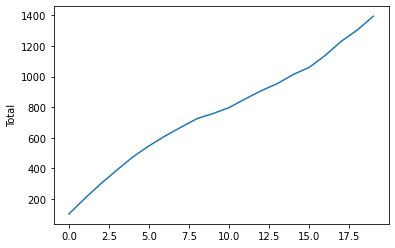

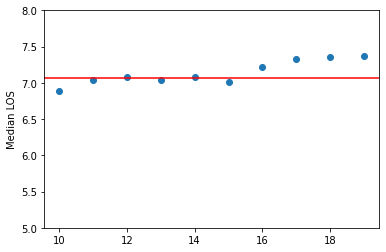

In [286]:
fig, ax = plt.subplots(1,1)
ax.plot(times, total_hosped)
ax.set_ylabel('Total')


fig, ax = plt.subplots(1,1)
ax.scatter(times[10:], median_los_7day[10:])
ax.axhline(true_median, color='r')
ax.set_ylim(5,8)
ax.set_ylabel('Median LOS')
